In [1]:
import pybullet as p
import pybullet_data
import time
import math
import random
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque


In [3]:
# Connect and set up environment
p.connect(p.GUI)
p.setGravity(0, 0, -9.81)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.loadURDF("plane.urdf")


0

In [4]:
# Parameters
cart_pos_range = (-4.0, 4.0)
cart_vel_range = (-6.0, 6.0)
pole_angle_range = (-0.26, 0.26)
pole_vel_range = (-5.5, 5.5)

In [5]:
# Create cart (base)
cart_half_extents = [0.2, 0.1, 0.05]
cart_collision = p.createCollisionShape(p.GEOM_BOX, halfExtents=cart_half_extents)
cart_visual = p.createVisualShape(p.GEOM_BOX, halfExtents=cart_half_extents, rgbaColor=[0, 0, 1, 1])

# Create pole (link)
pole_half_extents = [0.02, 0.02, 0.4]
pole_collision = p.createCollisionShape(p.GEOM_BOX, halfExtents=pole_half_extents, collisionFramePosition=[0, 0, pole_half_extents[2]])
pole_visual = p.createVisualShape(p.GEOM_BOX, halfExtents=pole_half_extents, visualFramePosition=[0, 0, pole_half_extents[2]], rgbaColor=[0, 1, 0, 1])

# Define link properties (pendulum attached to cart)
link_masses = [0.2]
link_collision_shapes = [pole_collision]
link_visual_shapes = [pole_visual]
link_positions = [[0, 0, cart_half_extents[2]]]# + pole_half_extents[2]]]  # joint position relative to cart
link_orientations = [[0, 0, 0, 1]]
link_inertial_frames = [[0, 0, pole_half_extents[2]], [0, 0, 0, 1]]
link_joint_types = [p.JOINT_REVOLUTE]
link_joint_axes = [[0, 1, 0]]  # Rotation around Y axis

# Create cart-pole as one multibody
cartpole = p.createMultiBody(
    baseMass=0.4,
    baseCollisionShapeIndex=cart_collision,
    baseVisualShapeIndex=cart_visual,
    basePosition=[0, 0, 1],
    
    linkMasses=link_masses,
    linkCollisionShapeIndices=link_collision_shapes,
    linkVisualShapeIndices=link_visual_shapes,
    linkPositions=link_positions,
    linkOrientations=link_orientations,
    linkInertialFramePositions=[[0, 0, pole_half_extents[2]]],
    linkInertialFrameOrientations=[[0, 0, 0, 1]],
    linkParentIndices=[0],
    linkJointTypes=link_joint_types,
    linkJointAxis=link_joint_axes,
)   


In [6]:
# Create constraint to fix the cart in the air
cart_constraint = p.createConstraint(
    parentBodyUniqueId=cartpole,
    parentLinkIndex=-1,
    childBodyUniqueId=-1,     # -1 means world
    childLinkIndex=0,
    jointType=p.JOINT_PRISMATIC,
    jointAxis=[1, 0, 0],
    parentFramePosition=[0, 0, 0],
    childFramePosition=[0, 0, 2]
)

In [7]:
def reset_environment():
    cart_pos = 0
    cart_vel = 0
    pole_angle = math.pi
    pole_angle1 = math.pi
    pole_vel = 0
    pole_vel1 = 0
    state = [float(cart_pos), float(cart_vel), float(pole_angle), float(pole_vel)]

    pos = random.uniform(-3.5, 3.5)
    ang_pos = random.uniform(-math.pi, math.pi)

    # 1. Reset cart (base position + orientation)
    p.resetBasePositionAndOrientation(
        cartpole,
        posObj=[0, 0, 2],      # origin, slight height above ground
        ornObj=[0, 0, 0, 1]      # no rotation
    )
    # 2. Reset cart linear and angular velocities
    p.resetBaseVelocity(
        cartpole,
        linearVelocity=[0, 0, 0],
        angularVelocity=[0, 0, 0]
    )
    # 3. Reset pole joint angle and angular velocity
    p.resetJointState(
       cartpole,
       jointIndex=0,
       targetValue= math.pi,     # upside down
       targetVelocity=0
    )
    # 4. Turn off motor again (important!)
    p.setJointMotorControl2(
        bodyIndex=cartpole,
        jointIndex=0,
        controlMode=p.VELOCITY_CONTROL,
        targetVelocity=0,
        force=0.02   # acts like joint friction
    )
    p.resetDebugVisualizerCamera(
       cameraDistance=6,              # Zoom out enough to see full motion
       cameraYaw=0,                     # 0° yaw: look along +x direction
       cameraPitch=-30,                 # Slightly tilted down
       cameraTargetPosition=[0, 0, 0.5] # Center on cart level
    )

    return state
    

In [8]:
state_size=4
action_size=2
# Define Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)
    
    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


In [9]:
# Replay Buffer
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.memory = deque(maxlen=buffer_size)
    
    def add(self, experience):
        self.memory.append(experience)
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)


In [10]:
# DQN Agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        
        self.q_network = QNetwork(state_size, action_size)
        self.target_network = QNetwork(state_size, action_size)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=1e-3)
        
        self.buffer = ReplayBuffer(buffer_size=10000)
        self.batch_size = 64
        self.gamma = 0.99
        self.update_every = 100  # how often to update target network
        self.tau = 0.001  # soft update parameter
        
        self.steps = 0
    
    def select_action(self, state, epsilon):
        if random.random() < epsilon:
            return random.randint(0, self.action_size - 1)
        else:
            state = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.q_network(state)
            return torch.argmax(q_values).item()

    def train(self):
        if len(self.buffer) < self.batch_size:
            return
        
        experiences = self.buffer.sample(self.batch_size)
        
        states, actions, rewards, next_states, dones = zip(*experiences)
        
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)
        
        # Q-values for current states
        q_values = self.q_network(states).gather(1, actions)
        
        # Q-values for next states (from target network)
        with torch.no_grad():
            max_next_q_values = self.target_network(next_states).max(1)[0].unsqueeze(1)
            target_q_values = rewards + (1 - dones) * self.gamma * max_next_q_values

        loss = nn.MSELoss()(q_values, target_q_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Soft update of target network
        for target_param, local_param in zip(self.target_network.parameters(), self.q_network.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)
    
    # Simulate
    def step(self, action):
  
        if action == 1:
            # Apply force to push right
            p.applyExternalForce(cartpole, -1, [x, 0, 0], [0, 0, 0], p.WORLD_FRAME)
        else:
            p.applyExternalForce(cartpole, -1, [-x, 0, 0], [0, 0, 0], p.WORLD_FRAME)
       
        p.stepSimulation()

        # Get cart position and orientation
        cart_pos, cart_orn = p.getBasePositionAndOrientation(cartpole)
        # Get cart linear and angular velocity
        cart_lin_vel, cart_ang_vel = p.getBaseVelocity(cartpole)

        #add friction to prismatic joint
        p.applyExternalForce(cartpole, -1, [-friction_coefficient * cart_lin_vel[0], 0, 0], [0, 0, 2], p.WORLD_FRAME)

        # Get pole joint state
        joint_state = p.getJointState(cartpole, 0)
        pole_angle = joint_state[0]        # joint position (in radians)
        pole_ang_vel = joint_state[1]      # joint velocity (rad/s)

        next_state = [float(cart_pos[0]), float(cart_lin_vel[0]), float(pole_angle), float(pole_ang_vel)]

        angle_penalty = pole_angle**2
        velocity_penalty = 0.01 * (pole_ang_vel**2)
        position_penalty = 0.1 * (cart_pos[0]**2 + cart_lin_vel[0]**2)
        penalty = angle_penalty + velocity_penalty + position_penalty

        reward = 10.0 - penalty
        done = False
        #if (pole_angle < 0.02) and (pole_angle > -0.02) and (pole_ang_vel < 0.3) and (pole_ang_vel > -0.3):
         #   reward = 10
          #  done = False
        if (cart_pos[0]<cart_pos_range[0]) or (cart_pos[0]>cart_pos_range[1]): # or (pole_angle1<pole_angle_range[0]) or (pole_angle1>pole_angle_range[1])):# or (pole_ang_vel>pole_vel_range[1]) or (pole_ang_vel<pole_vel_range[0]):
            reward = -10
            done = True

        #print(f"Cart X = {cart_pos[0]:.3f}, Cart Vel = {cart_lin_vel[0]:.3f} m/s, Pole Angle = {pole_angle:.3f} rad , Pole Vel = {pole_ang_vel:.3f} rad/s")
    
        #time.sleep(1/1000)
        return next_state, reward, done, pole_angle, penalty, cart_pos

friction_coefficient=0.002
x=20 

In [11]:
# Training loop
def train_dqn(agent, n_episodes=20000, max_steps=1500, epsilon_start=0.5, epsilon_end=0.1, epsilon_decay=0.9999):
    scores = []
    epsilon = 0.4
    for episode in range(n_episodes):
        state = reset_environment()
        total_reward = 0
        max_pole = 0
        if random.random() < 0.1:
            p.applyExternalForce(cartpole, 0, [-20, 0, 0], [0, 0, 0], p.WORLD_FRAME)
            
        
        for step in range(max_steps):
            action = agent.select_action(state, epsilon)
            next_state, reward, done, pole_angle, penalty, cart_pos = agent.step(action)
            max_pole = max(max_pole, pole_angle)

            
            agent.buffer.add((state, action, reward, next_state, done))
            agent.train()
            
            state = next_state
            total_reward += reward
            
            if done:
                break
        
        epsilon = max(epsilon_end, epsilon_decay * epsilon)
        scores.append(total_reward)
        
        print(f"Episode {episode}, Score: {total_reward: .3f}, Epsilon: {epsilon:.3f}, Pole:{max_pole:.3f}, Penalty:{penalty:.3f} ")
    
    return scores

In [12]:
# First create an instance
agent = DQNAgent(state_size=4, action_size=2)   # <--- adjust 6 and 2 to your state/action size


In [18]:
# Load saved weights
agent.q_network.load_state_dict(torch.load('dqn_single_cartpoleP.pth'))
agent.target_network.load_state_dict(agent.q_network.state_dict())

C:\Users\moham\AppData\Local\Temp\ipykernel_23364\1024547845.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.q_network.load_state_dict(torch.load('dqn_single_cartp

<All keys matched successfully>

In [24]:
p.configureDebugVisualizer(p.COV_ENABLE_RENDERING, 0)

In [ ]:
p.configureDebugVisualizer(p.COV_ENABLE_RENDERING, 1)

In [29]:
trained_values = train_dqn(agent)
trained_values

Episode 0, Score:  13676.673, Epsilon: 0.400, Pole:3.140, Penalty:1.507 
Episode 1, Score:  10687.306, Epsilon: 0.400, Pole:3.140, Penalty:10.533 
Episode 2, Score:  602.959, Epsilon: 0.400, Pole:3.719, Penalty:17.585 
Episode 3, Score:  681.383, Epsilon: 0.400, Pole:3.375, Penalty:12.216 
Episode 4, Score: -1747.300, Epsilon: 0.400, Pole:3.140, Penalty:38.314 
Episode 5, Score:  1916.408, Epsilon: 0.400, Pole:4.342, Penalty:24.775 
Episode 6, Score:  2919.722, Epsilon: 0.400, Pole:3.140, Penalty:14.841 
Episode 7, Score:  4207.494, Epsilon: 0.400, Pole:3.140, Penalty:14.635 
Episode 8, Score:  1270.005, Epsilon: 0.400, Pole:3.539, Penalty:18.615 
Episode 9, Score:  1046.969, Epsilon: 0.400, Pole:4.288, Penalty:22.053 
Episode 10, Score:  961.226, Epsilon: 0.400, Pole:4.294, Penalty:21.731 
Episode 11, Score:  1163.057, Epsilon: 0.400, Pole:4.417, Penalty:22.822 
Episode 12, Score:  564.452, Epsilon: 0.399, Pole:4.064, Penalty:21.045 
Episode 13, Score:  569.926, Epsilon: 0.399, Pole:4

KeyboardInterrupt: 

In [30]:
torch.save(agent.q_network.state_dict(), 'dqn_single_cartpoleP.pth')
print("Model saved successfully!")

Model saved successfully!


In [21]:
def test_dqn(agent, n_episodes, max_steps):
    #Angle = []
    for episode in range(n_episodes):
        state = reset_environment()
        total_reward = 0
        sum_angle = []
        
        for t in range(max_steps):
            action = agent.select_action(state, epsilon=0.0)  # Greedy action (no exploration)
            next_state, reward, done, pole_angle, penalty, cart_pos = agent.step(action)

            if t == 500:
                p.applyExternalForce(cartpole, 0, [-20, 0, 0], [0, 0, 0], p.WORLD_FRAME)
            
            state = next_state
            total_reward += reward
            sum_angle.append(pole_angle)
            
            time.sleep(1/1000000)
            
            if done:
                break
        
            print(f"Step {t}, Total Reward: {total_reward}, Angle: {pole_angle}")
        #Angle.append(sum_angle)
            #return(sum_angle)
    plt.figure(figsize=(5, 5))
    plt.plot(sum_angle, label='Pole 1 Angle')
    plt.xlabel('Timestep')
    plt.ylabel('Pole-Angle (rad)')
    plt.title('Pole Angles During Test Episode')
    plt.legend()
    plt.grid(True)
    plt.savefig('Pole_angles.png', dpi=300, bbox_inches='tight')
    plt.show()


Step 0, Total Reward: 0.13480731314201044, Angle: 3.140157909400823
Step 1, Total Reward: 0.2738262498045927, Angle: 3.137289396338011
Step 2, Total Reward: 0.41683946336877575, Angle: 3.1329888241006993
Step 3, Total Reward: 0.5636055771820594, Angle: 3.127258716843445
Step 4, Total Reward: 0.7138537995509644, Angle: 3.120102487455073
Step 5, Total Reward: 0.8672805167749882, Angle: 3.1115245365504594
Step 6, Total Reward: 1.0235484241000865, Angle: 3.1015303750860106
Step 7, Total Reward: 1.1822887107484767, Angle: 3.090126769089245
Step 8, Total Reward: 1.3431067520475022, Angle: 3.0773219044540863
Step 9, Total Reward: 1.5055916747280627, Angle: 3.0631255691153054
Step 10, Total Reward: 1.669330046203786, Angle: 3.0475493491731225
Step 11, Total Reward: 1.8339237915384246, Angle: 3.0306068347070356
Step 12, Total Reward: 1.999012261025415, Angle: 3.012313830124003
Step 13, Total Reward: 2.1642981576463054, Angle: 2.9926885629734805
Step 14, Total Reward: 2.3295767915428094, Angle: 

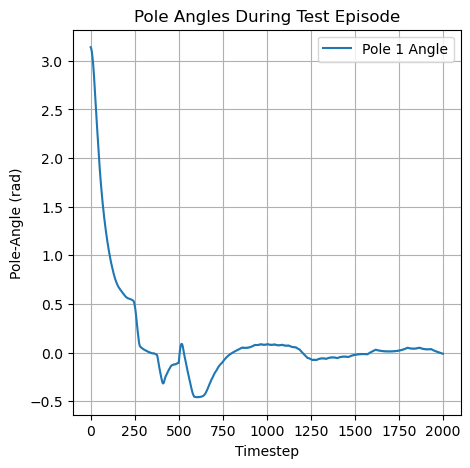

In [23]:
test_dqn(agent, n_episodes=1, max_steps=2000)